In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
#Importing all the necessary libraries for image processing
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.compat.v1.losses import sparse_softmax_cross_entropy


In [5]:
os.getcwd()


'c:\\Users\\sookm\\OneDrive\\Desktop\\work\\Breast Cancer Detection'

In [7]:
#Loading the text file
fold_df = pd.read_csv("./Folds.csv/Folds.csv")

In [8]:
#Defining the paths
img_path = "./BreaKHis_v1/"
classes = ["benign","malign"]

In [9]:
#Renaming the column filename to path
fold_df = fold_df.rename(columns = {"filename":"path"})
#Printing the head of the file
fold_df.head(3)

fold  mag    grp                                               path
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...

In [10]:
#One example path is printed
fold_df['path'][1]

'BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-002.png'

In [11]:
#Extracting the filename and label from the path column
fold_df['filename'] = fold_df['path'].apply(lambda x:x.split("/")[-1])
fold_df["label"] = fold_df['path'].apply(lambda x: x.split("/")[3])

In [12]:
fold_df.head(3)


fold  mag    grp                                               path  \
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   

                         filename   label  
0  SOB_B_A-14-22549AB-100-001.png  benign  
1  SOB_B_A-14-22549AB-100-002.png  benign  
2  SOB_B_A-14-22549AB-100-003.png  benign

Creating New Directiory Cancer

- The given data consists of very complex structure of folders where it stores the images.
- The structure as follows:
- BreaKHis_v1
  - histology_slides
    - breast
      - benign
        - SOB
         - Type - patient_id
         - 40x - 100x - 200x - 400x
      - malignant
        - SOB
         - Type - patient_id
         - 40x - 100x - 200x - 400x
         
- To make things simple, using the exact path of the images, all the images are moved to the common folder called Cancer.
- Images are renamed with their class and patient_id.

In [13]:
#Creating new directory
os.makedirs("./Cancer/")

In [14]:
#Moving all the images to one folder
for p in fold_df['path']:
    src = "./BreaKHis_v1/" + p
    dest = "./Cancer/"
    #saving the files with its corresponding class and patient_id
    dest = os.path.join(dest,src.split("/")[5]+ "_" + src.split("/")[-1])
    shutil.copyfile(src,dest)   

In [15]:
#Checking the len
len(os.listdir("./Cancer/"))

7909

In [16]:
#Creating a new data frame with labels and file names stored in single folder
fold_df['file_loc'] = fold_df['label'] + "_" + fold_df['filename']
#Encoding the class to integer
fold_df['class'] = fold_df['label'].apply(lambda x: 0 if x =='benign' else 1)

In [17]:
#Printing the head to display the changed made
fold_df.head(3)

fold  mag    grp                                               path  \
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   

                         filename   label  \
0  SOB_B_A-14-22549AB-100-001.png  benign   
1  SOB_B_A-14-22549AB-100-002.png  benign   
2  SOB_B_A-14-22549AB-100-003.png  benign   

                                file_loc  class  
0  benign_SOB_B_A-14-22549AB-100-001.png      0  
1  benign_SOB_B_A-14-22549AB-100-002.png      0  
2  benign_SOB_B_A-14-22549AB-100-003.png      0

Text(0.5, 1.0, 'No of Patients Benign and Malignant')

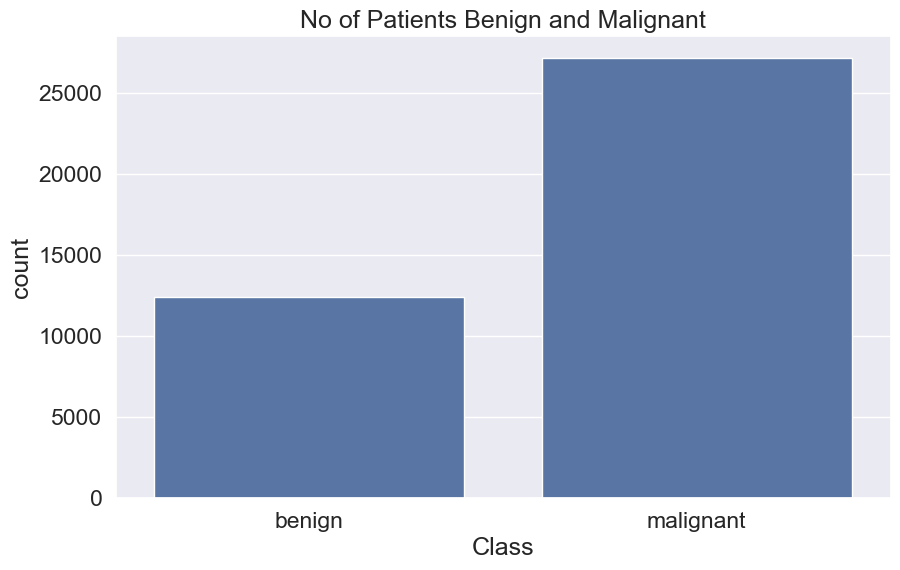

In [18]:
#Lets explore the data set
plt.figure(figsize=(10,6))
sns.set(font_scale = 1.5)
sns.set_style("darkgrid")
sns.countplot(data=fold_df, x='label')
plt.xlabel("Class")
plt.title("No of Patients Benign and Malignant")

In [19]:
#Filtering the data frame to benign and malignant for visualization
benign_df = fold_df[fold_df['label'] == 'benign']
malignant_df = fold_df[fold_df['label'] == 'malignant']

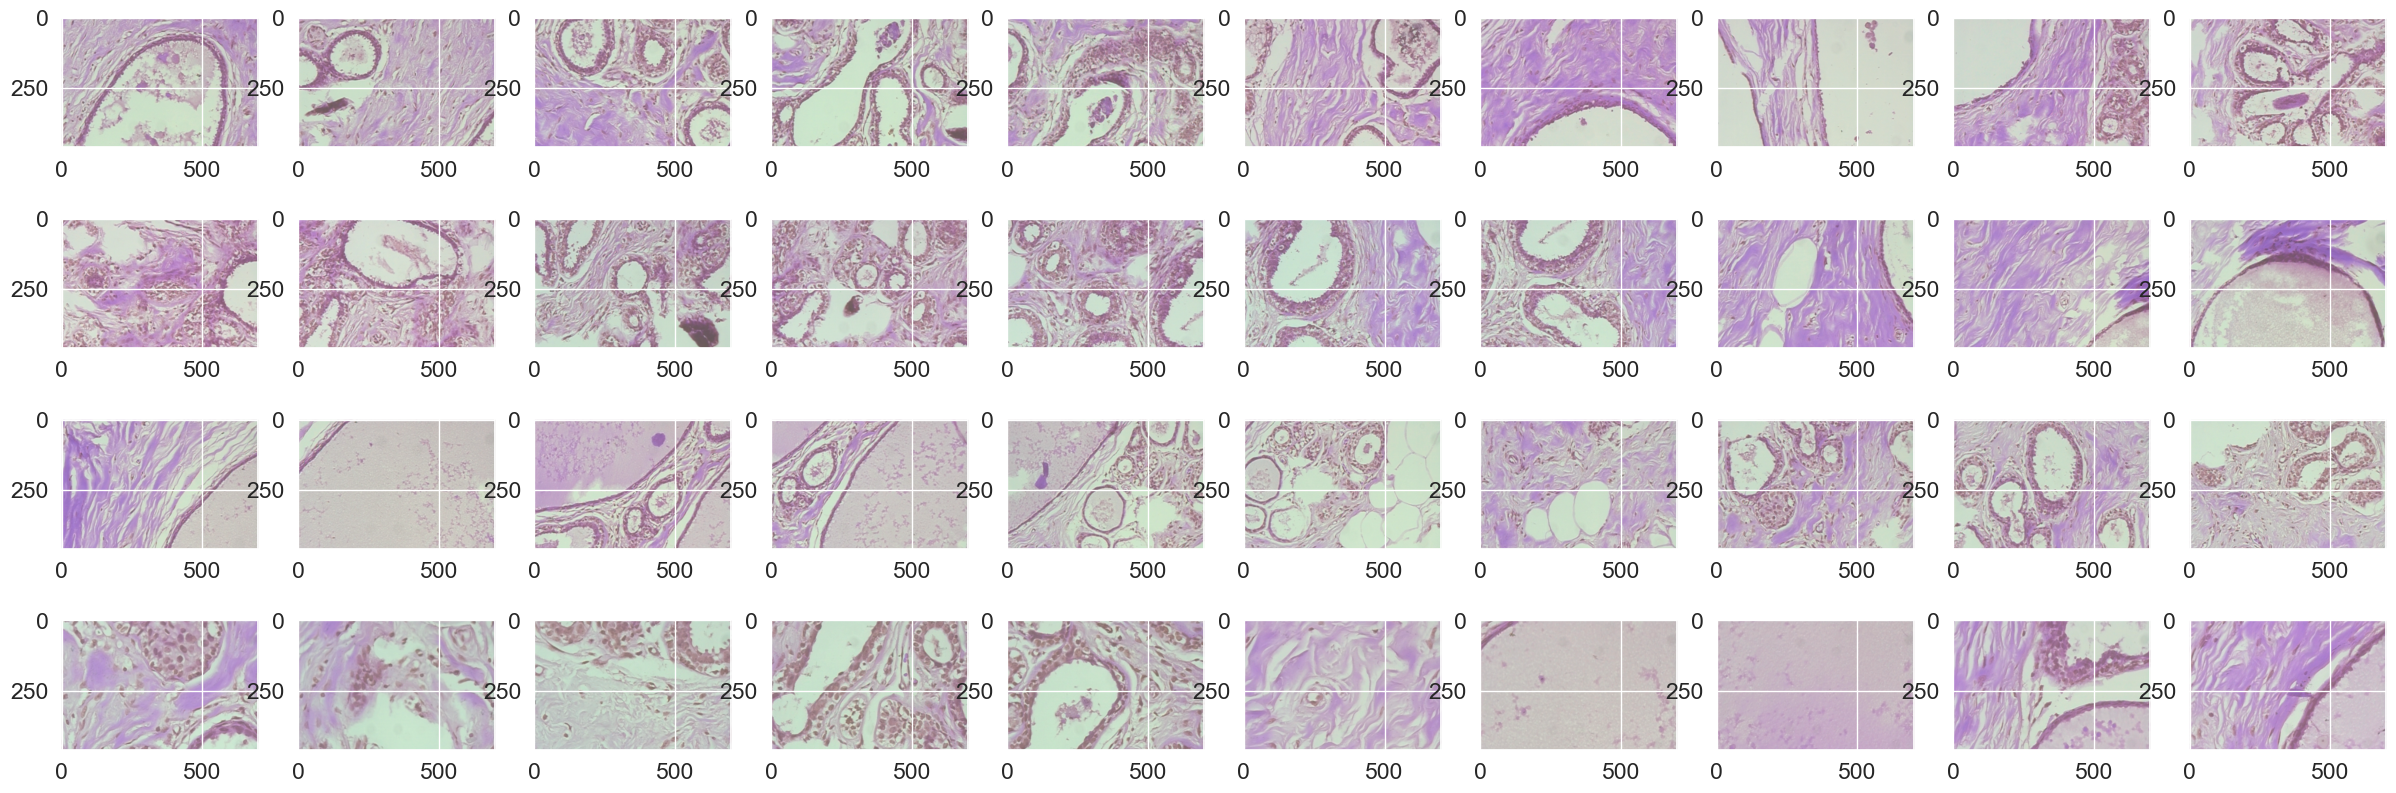

In [20]:
#Plotting the benign samples
plt.figure(figsize = (30,10))
for i in range(0,40):
    plt.subplot(4,10,i+1)
    img = cv2.imread("./Cancer/"+ benign_df['file_loc'][i],1)
    plt.imshow(img)

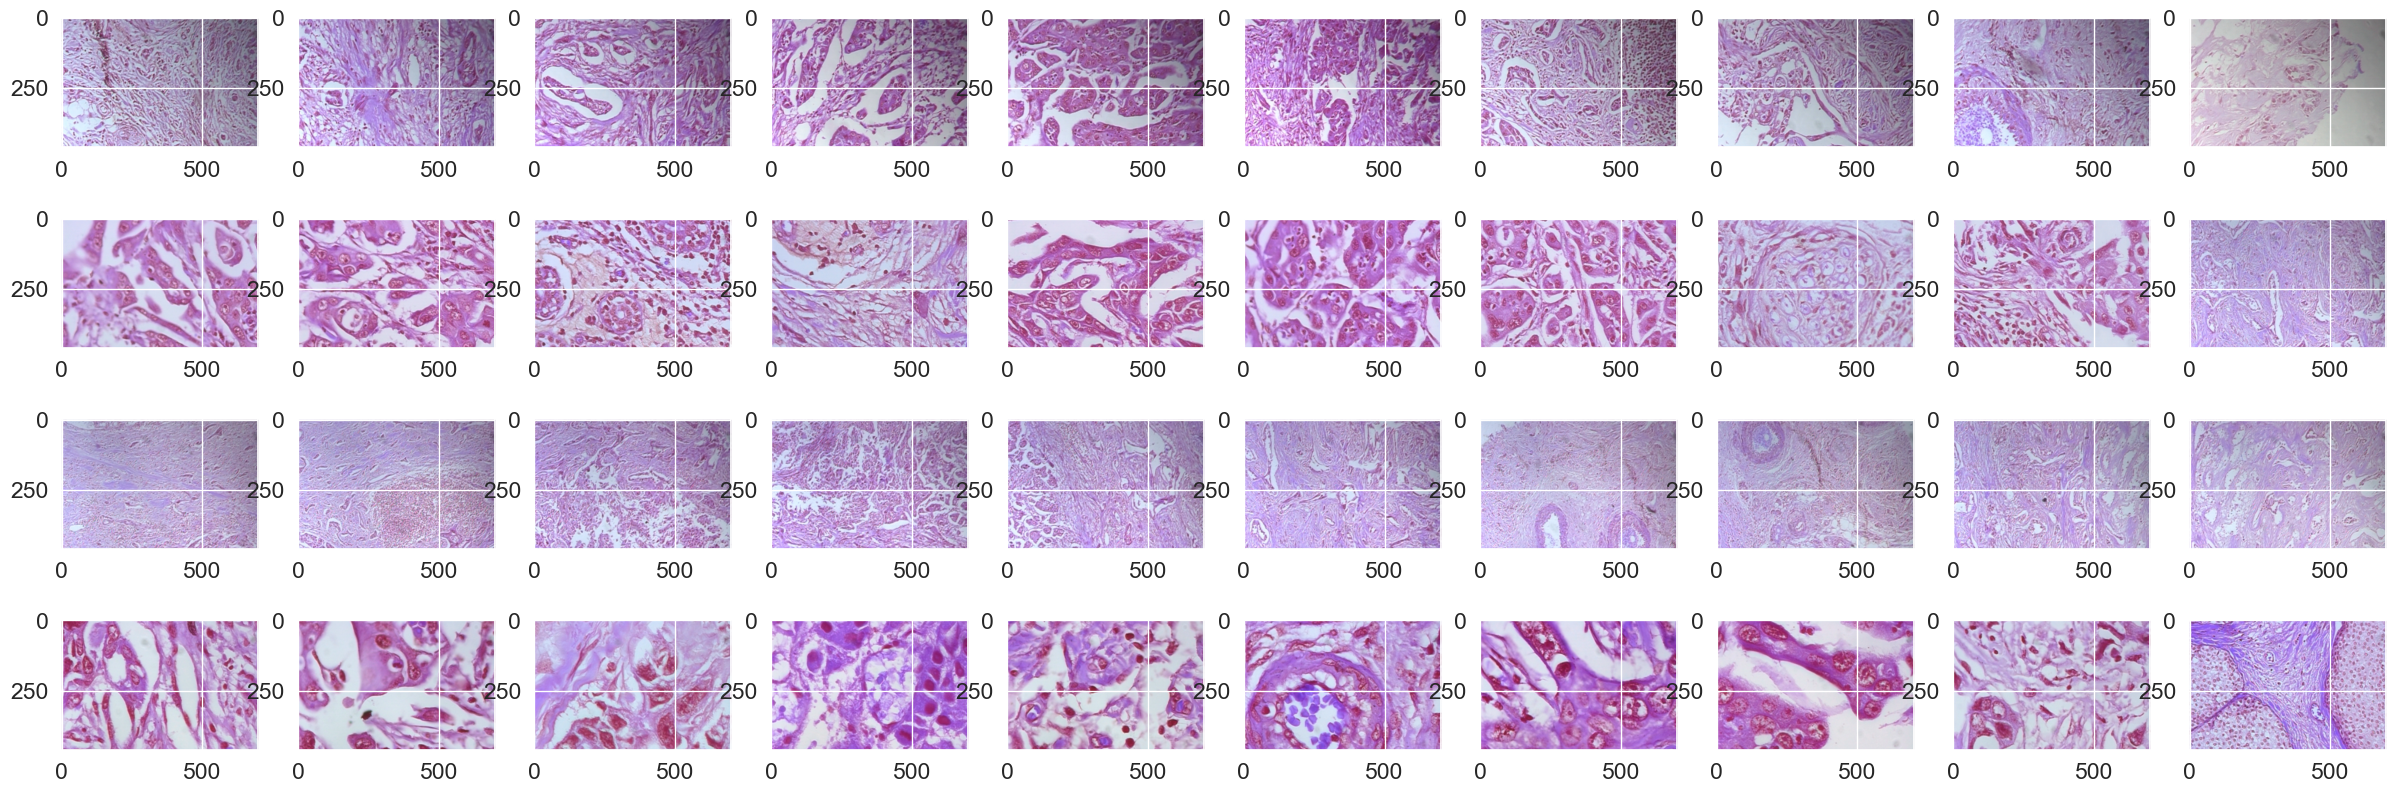

In [21]:
#Plotting the malignant samples
images = malignant_df['file_loc'].values
plt.figure(figsize = (30,10))
for i in range(0,40):
    plt.subplot(4,10,i+1)
    img = cv2.imread("./Cancer/"+ images[i],1)
    plt.imshow(img)

In [22]:
#Creating a new data frame with the file loc as its index, label and class of the patients as its columns.
df = pd.DataFrame(os.listdir("./Cancer/"))
df = df.rename(columns = {0:'file_loc'})
df['label'] = df['file_loc'].apply(lambda x:x.split("_")[0])
df['class'] = df['label'].apply(lambda x: 0 if x =='benign' else 1)
df.set_index("file_loc",inplace=True)

In [23]:
#Checking the data frame
df.head(10)

label  class
file_loc                                            
benign_SOB_B_A-14-22549AB-100-001.png  benign      0
benign_SOB_B_A-14-22549AB-100-002.png  benign      0
benign_SOB_B_A-14-22549AB-100-003.png  benign      0
benign_SOB_B_A-14-22549AB-100-004.png  benign      0
benign_SOB_B_A-14-22549AB-100-005.png  benign      0
benign_SOB_B_A-14-22549AB-100-006.png  benign      0
benign_SOB_B_A-14-22549AB-100-007.png  benign      0
benign_SOB_B_A-14-22549AB-100-008.png  benign      0
benign_SOB_B_A-14-22549AB-100-009.png  benign      0
benign_SOB_B_A-14-22549AB-100-010.png  benign      0

In [24]:
#Checking the data frame
df.tail(10)

label  class
file_loc                                                 
malignant_SOB_M_PC-15-190EF-400-006.png  malignant      1
malignant_SOB_M_PC-15-190EF-400-007.png  malignant      1
malignant_SOB_M_PC-15-190EF-400-008.png  malignant      1
malignant_SOB_M_PC-15-190EF-400-009.png  malignant      1
malignant_SOB_M_PC-15-190EF-400-010.png  malignant      1
malignant_SOB_M_PC-15-190EF-400-011.png  malignant      1
malignant_SOB_M_PC-15-190EF-400-012.png  malignant      1
malignant_SOB_M_PC-15-190EF-400-013.png  malignant      1
malignant_SOB_M_PC-15-190EF-400-014.png  malignant      1
malignant_SOB_M_PC-15-190EF-400-015.png  malignant      1

Using the data frame, the splitting for train, test and validation is done.
- 10% -> test data
- 10% -> validation data.
- 80% -> training data.

In [25]:
#Performing the splitting
data_train_and_val, data_test = train_test_split(df, test_size = 0.1, random_state = 47)
#Traing and val
data_train, data_val = train_test_split(data_train_and_val, test_size = 0.1, random_state = 47)

In [26]:
print("Training size :", data_train.shape)
print("Validation size :", data_val.shape)
print("Testing size :", data_test.shape)

Training size : (6406, 2)
Validation size : (712, 2)
Testing size : (791, 2)


In [27]:
print('Training set')
print(data_train.label.value_counts())

print('\nValidation set')
print(data_val.label.value_counts())

print('\nTest set')
print(data_test.label.value_counts())

Training set
label
malignant    4400
benign       2006
Name: count, dtype: int64

Validation set
label
malignant    502
benign       210
Name: count, dtype: int64

Test set
label
malignant    527
benign       264
Name: count, dtype: int64


In [28]:
#Separating the benign and malignant patients from train data
train_has_cancer = data_train[data_train['class'] == 1]
train_has_no_cancer = data_train[data_train['class'] == 0]

In [29]:
#Upsampling the minority class by the size of majority class with replacement
train_has_no_cancer_upsample = resample(train_has_no_cancer, n_samples = len(train_has_cancer), random_state = 47, replace = True)

In [30]:
#Concatenating the upsampled minority class and the majority class
data_train = pd.concat([train_has_cancer,train_has_no_cancer_upsample])

In [31]:
print('Training set')
print(data_train.label.value_counts())

print('\nValidation set')
print(data_val.label.value_counts())

print('\nTest set')
print(data_test.label.value_counts())

Training set
label
malignant    4400
benign       4400
Name: count, dtype: int64

Validation set
label
malignant    502
benign       210
Name: count, dtype: int64

Test set
label
malignant    527
benign       264
Name: count, dtype: int64


Creating the directory structure for Training , Validation and Testing:
- Earlier all the images where stored in the single directory called Cancer.
- Now we are using Image data generator as part of our algorithm designing.
- Image data generator expects the Images to be in the following structure:
    - Train
        - Benign
        - Malignant
    - Validation
        - Benign
        - Malignant
    - Testing
        - Benign
        - Malignant
- Above structure is the prerequisite for the Image Data Generator to run.

In [32]:
#Creating the directories to store images
os.makedirs("./Cancer_train")
os.makedirs("./Cancer_test")
os.makedirs("./Cancer_validation")
os.makedirs("./Cancer_train/benign")
os.makedirs("./Cancer_train/malignant")
os.makedirs("./Cancer_validation/benign")
os.makedirs("./Cancer_validation/malignant")
os.makedirs("./Cancer_test/benign")
os.makedirs("./Cancer_test/malignant")

- Using the above directories and the splitted data frames data_train, data_val, data_test.
- We are moving the images to the corresponding directories based on the class of the image(Benign or Malignant).

In [33]:
#Training data
i = 1
for img in data_train.index:
    if img!=".DS_Store":
        target = df.loc[img,'class']
        if target == 1:
            label = 'malignant'
        else:          
            label = 'benign'      
        src = os.path.join("./Cancer/",img)
        dest = os.path.join("./Cancer_train/",label, "image" + str(i)+".png")
        img1 = np.array(cv2.imread(src))
        cv2.imwrite(dest,img1)
        i = i+1

In [34]:
#Validation data
for img in data_val.index:
    target = data_val.loc[img,'class']
    if target == 1:
        label = 'malignant'
    else:
        label = 'benign'
        
    src = os.path.join("./Cancer/",img)
    dest = os.path.join("./Cancer_validation/",label,img)
    shutil.copyfile(src,dest)

In [35]:
#Testing data
for img in data_test.index:
    target = data_test.loc[img,'class']
    if target == 1:
        label = 'malignant'
    else:
        label = 'benign'
        
    src = os.path.join("./Cancer/",img)
    dest = os.path.join("./Cancer_test/",label,img)
    shutil.copyfile(src,dest)

In [36]:
#Checking their lengths
print("Training Data:")
print(" ")
print("Benign:",len(os.listdir("./Cancer_train/benign/")))
print("Malignant::",len(os.listdir("./Cancer_train/malignant/")))
print(" ")
print("Validation Data")
print(" ")
print("Benign size:",len(os.listdir("./Cancer_validation/benign/")))
print("Malignant size :",len(os.listdir("./Cancer_validation/malignant/")))
print(" ")
print("Testing Data:")
print(" ")
print("Benign size :",len(os.listdir("./Cancer_test/benign/")))
print("Malignant size :",len(os.listdir("./Cancer_test/malignant/")))

Training Data:
 
Benign: 4400
Malignant:: 4400
 
Validation Data
 
Benign size: 210
Malignant size : 502
 
Testing Data:
 
Benign size : 264
Malignant size : 527


Image Data Generator
- Generates batches of tensor image data with real-time data augmentation.
- Thus CNN sees new set of images with different variation at each epoch.

In [37]:
#Defining Image Data Generator
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.2)

Here the Image Data Generator is defined with following functions:
- Random rotation by 20 degrees.
- Horizontal flip.
- Vertical flip.
- Rescale image by its pixel value.
- Randomly Zoom image by 20%.
- Random shear by 20%.

Flow from Directory
- Here the flow_from_directory will find the number of images and their classes based on the hierarchy.
- Size of the image is set to 128x128.
- Batch size of 32 and class mode of binary(Benign or Malignant).

In [38]:
#Setting up the images for image data generator
train_generation = datagen.flow_from_directory("./Cancer_train/",target_size=(128,128),batch_size = 32, class_mode="binary")
val_generation = datagen.flow_from_directory("./Cancer_validation/", target_size=(128,128), batch_size=32, class_mode="binary")

Found 8800 images belonging to 2 classes.
Found 712 images belonging to 2 classes.


CNN Architecture
- CNN architecture is defined using Conv2D layers and Maxpooling layers.
- Dropout Layers are added to randomly turn off some neurons while training to prevent from overfitting.
- Flatten layer is added at the end to form Dense Layers.
- relu is used as activation in all the layers and Sigmoid as the activation in the output layer.

In [39]:
#Defining the base model
cancer_model = Sequential()

#First Layer
cancer_model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (128,128,3), activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Second Layer
cancer_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Third Layer
cancer_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.4))

#Fourth Layer
cancer_model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.2))

#Flattening the layers
cancer_model.add(Flatten())

#Adding the dense layer
cancer_model.add(Dense(256, activation = 'relu'))
cancer_model.add(Dense(128, activation = 'relu'))
cancer_model.add(Dense(1, activation = 'sigmoid'))

cancer_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 128)      

In [40]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=20*50,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

Model Compilation
- Model is compiled by using binary crossentropy as the loss function and adam optimizer to optimize the weights.
- Early stopping is involved to monitor validation loss inorder to prevent overfitting with patience level = 5
- Modelcheckpoint is used to store the best models for every epoch.

In [41]:
#Compiling the model
cancer_model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

Model Fit
- Model is fitted using train and validation generators generated using Image DataGenerator.
- Verbose is set to 1 to monitor accuracy and losses.
- Model is trained for 200 epochs.
- early stopping and checkpoint are used as the call backs.

In [43]:
#Model is fitted using train and validation generator for 200 epochs
history = cancer_model.fit(train_generation, validation_data=val_generation, epochs=200 ,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/200


275/275 [==============================] - ETA: 0s - loss: 0.5247 - accuracy: 0.7598INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 392s 1s/step - loss: 0.5247 - accuracy: 0.7598 - val_loss: 0.6535 - val_accuracy: 0.7781
Epoch 2/200
275/275 [==============================] - ETA: 0s - loss: 0.4664 - accuracy: 0.8062INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 264s 961ms/step - loss: 0.4664 - accuracy: 0.8062 - val_loss: 0.4404 - val_accuracy: 0.8525
Epoch 3/200
275/275 [==============================] - 298s 1s/step - loss: 0.4611 - accuracy: 0.8075 - val_loss: 0.5330 - val_accuracy: 0.7781
Epoch 4/200
275/275 [==============================] - ETA: 0s - loss: 0.4393 - accuracy: 0.8164INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 354s 1s/step - loss: 0.4393 - accuracy: 0.8164 - val_loss: 0.4194 - val_accuracy: 0.8483
Epoch 5/200
275/275 [==============================] - 273s 992ms/step - loss: 0.4133 - accuracy: 0.8248 - val_loss: 0.4703 - val_accuracy: 0.8244
Epoch 6/200
275/275 [==============================] - ETA: 0s - loss: 0.3974 - accuracy: 0.8251INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 307s 1s/step - loss: 0.3974 - accuracy: 0.8251 - val_loss: 0.3911 - val_accuracy: 0.8427
Epoch 7/200
275/275 [==============================] - ETA: 0s - loss: 0.3635 - accuracy: 0.8425INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 307s 1s/step - loss: 0.3635 - accuracy: 0.8425 - val_loss: 0.3530 - val_accuracy: 0.8708
Epoch 8/200
275/275 [==============================] - ETA: 0s - loss: 0.3473 - accuracy: 0.8489INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 312s 1s/step - loss: 0.3473 - accuracy: 0.8489 - val_loss: 0.3395 - val_accuracy: 0.8638
Epoch 9/200
275/275 [==============================] - 289s 1s/step - loss: 0.3175 - accuracy: 0.8608 - val_loss: 0.3879 - val_accuracy: 0.8202
Epoch 10/200
275/275 [==============================] - 447s 2s/step - loss: 0.3048 - accuracy: 0.8695 - val_loss: 0.3709 - val_accuracy: 0.8371
Epoch 11/200
275/275 [==============================] - ETA: 0s - loss: 0.2813 - accuracy: 0.8836INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 326s 1s/step - loss: 0.2813 - accuracy: 0.8836 - val_loss: 0.2905 - val_accuracy: 0.8736
Epoch 12/200
275/275 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.8919INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 284s 1s/step - loss: 0.2629 - accuracy: 0.8919 - val_loss: 0.2533 - val_accuracy: 0.8975
Epoch 13/200
275/275 [==============================] - 263s 955ms/step - loss: 0.2506 - accuracy: 0.9003 - val_loss: 0.3356 - val_accuracy: 0.8652
Epoch 14/200
275/275 [==============================] - 274s 996ms/step - loss: 0.2331 - accuracy: 0.9040 - val_loss: 0.2592 - val_accuracy: 0.9003
Epoch 15/200
275/275 [==============================] - ETA: 0s - loss: 0.2338 - accuracy: 0.9028INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 266s 968ms/step - loss: 0.2338 - accuracy: 0.9028 - val_loss: 0.2466 - val_accuracy: 0.8961
Epoch 16/200
275/275 [==============================] - 305s 1s/step - loss: 0.2247 - accuracy: 0.9075 - val_loss: 0.2570 - val_accuracy: 0.8904
Epoch 17/200
275/275 [==============================] - 313s 1s/step - loss: 0.2068 - accuracy: 0.9141 - val_loss: 0.3242 - val_accuracy: 0.8497
Epoch 18/200
275/275 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.9127INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 342s 1s/step - loss: 0.2091 - accuracy: 0.9127 - val_loss: 0.2396 - val_accuracy: 0.8975
Epoch 19/200
275/275 [==============================] - ETA: 0s - loss: 0.1995 - accuracy: 0.9183INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 258s 938ms/step - loss: 0.1995 - accuracy: 0.9183 - val_loss: 0.2209 - val_accuracy: 0.9059
Epoch 20/200
275/275 [==============================] - 373s 1s/step - loss: 0.1974 - accuracy: 0.9200 - val_loss: 0.2486 - val_accuracy: 0.8904
Epoch 21/200
275/275 [==============================] - 346s 1s/step - loss: 0.1883 - accuracy: 0.9232 - val_loss: 0.2243 - val_accuracy: 0.9045
Epoch 22/200
275/275 [==============================] - 331s 1s/step - loss: 0.1862 - accuracy: 0.9240 - val_loss: 0.2243 - val_accuracy: 0.9045
Epoch 23/200
275/275 [==============================] - 304s 1s/step - loss: 0.1788 - accuracy: 0.9262 - val_loss: 0.2339 - val_accuracy: 0.9031
Epoch 24/200
275/275 [==============================] - ETA: 0s - loss: 0.1754 - accuracy: 0.9303INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 308s 1s/step - loss: 0.1754 - accuracy: 0.9303 - val_loss: 0.2164 - val_accuracy: 0.8961
Epoch 25/200
275/275 [==============================] - 300s 1s/step - loss: 0.1735 - accuracy: 0.9310 - val_loss: 0.2345 - val_accuracy: 0.8933
Epoch 26/200
275/275 [==============================] - ETA: 0s - loss: 0.1700 - accuracy: 0.9319INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 333s 1s/step - loss: 0.1700 - accuracy: 0.9319 - val_loss: 0.2143 - val_accuracy: 0.9185
Epoch 27/200
275/275 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9347INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 315s 1s/step - loss: 0.1609 - accuracy: 0.9347 - val_loss: 0.2119 - val_accuracy: 0.9129
Epoch 28/200
275/275 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.9361INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 275s 997ms/step - loss: 0.1586 - accuracy: 0.9361 - val_loss: 0.2015 - val_accuracy: 0.9199
Epoch 29/200
275/275 [==============================] - ETA: 0s - loss: 0.1566 - accuracy: 0.9362INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 342s 1s/step - loss: 0.1566 - accuracy: 0.9362 - val_loss: 0.1911 - val_accuracy: 0.9143
Epoch 30/200
275/275 [==============================] - 275s 999ms/step - loss: 0.1526 - accuracy: 0.9401 - val_loss: 0.2005 - val_accuracy: 0.9199
Epoch 31/200
275/275 [==============================] - 313s 1s/step - loss: 0.1507 - accuracy: 0.9410 - val_loss: 0.2238 - val_accuracy: 0.9059
Epoch 32/200
275/275 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.9453INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 316s 1s/step - loss: 0.1388 - accuracy: 0.9453 - val_loss: 0.1864 - val_accuracy: 0.9256
Epoch 33/200
275/275 [==============================] - ETA: 0s - loss: 0.1372 - accuracy: 0.9461INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 313s 1s/step - loss: 0.1372 - accuracy: 0.9461 - val_loss: 0.1793 - val_accuracy: 0.9354
Epoch 34/200
275/275 [==============================] - ETA: 0s - loss: 0.1329 - accuracy: 0.9495INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 282s 1s/step - loss: 0.1329 - accuracy: 0.9495 - val_loss: 0.1768 - val_accuracy: 0.9157
Epoch 35/200
275/275 [==============================] - 324s 1s/step - loss: 0.1340 - accuracy: 0.9470 - val_loss: 0.1913 - val_accuracy: 0.9256
Epoch 36/200
275/275 [==============================] - 330s 1s/step - loss: 0.1242 - accuracy: 0.9522 - val_loss: 0.1795 - val_accuracy: 0.9199
Epoch 37/200
275/275 [==============================] - 387s 1s/step - loss: 0.1357 - accuracy: 0.9476 - val_loss: 0.1938 - val_accuracy: 0.9213
Epoch 38/200
275/275 [==============================] - 306s 1s/step - loss: 0.1244 - accuracy: 0.9542 - val_loss: 0.1772 - val_accuracy: 0.9312
Epoch 39/200
275/275 [==============================] - ETA: 0s - loss: 0.1184 - accuracy: 0.9545INFO:tensorflow:Assets written to: ./Best_model\assets


INFO:tensorflow:Assets written to: ./Best_model\assets


275/275 [==============================] - 328s 1s/step - loss: 0.1184 - accuracy: 0.9545 - val_loss: 0.1572 - val_accuracy: 0.9410
Epoch 40/200
275/275 [==============================] - 328s 1s/step - loss: 0.1101 - accuracy: 0.9575 - val_loss: 0.1646 - val_accuracy: 0.9326
Epoch 41/200
275/275 [==============================] - 377s 1s/step - loss: 0.1075 - accuracy: 0.9595 - val_loss: 0.1667 - val_accuracy: 0.9452
Epoch 42/200
275/275 [==============================] - 349s 1s/step - loss: 0.1052 - accuracy: 0.9602 - val_loss: 0.1675 - val_accuracy: 0.9438
Epoch 43/200
275/275 [==============================] - 367s 1s/step - loss: 0.1063 - accuracy: 0.9605 - val_loss: 0.1638 - val_accuracy: 0.9410
Epoch 44/200
275/275 [==============================] - 318s 1s/step - loss: 0.1057 - accuracy: 0.9590 - val_loss: 0.1583 - val_accuracy: 0.9410


- The model is terminated after 44 epochs as it started overfitting.
- The model is terminated by Early stopping.
- The results are promising as the training accuracy is 95.90% while validation accuracy is 94.1%.

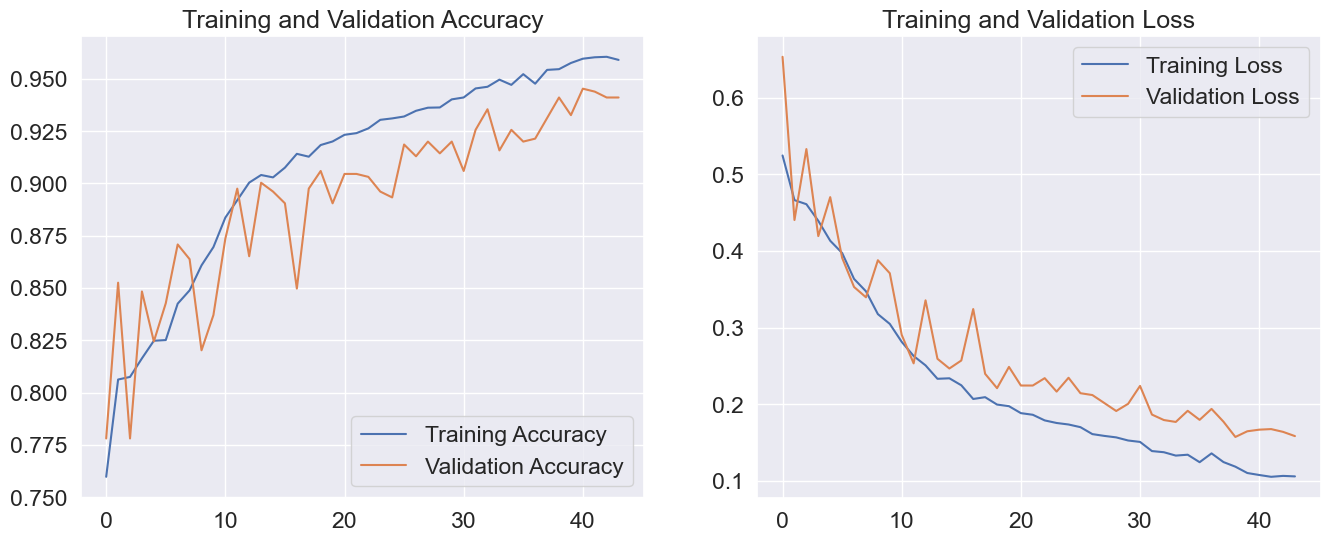

In [44]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [46]:
#Loading the test data using Image Data Generator
test_gen = datagen.flow_from_directory("./Cancer_test/", target_size=(128,128), class_mode="binary", batch_size=1, shuffle=False)

Found 791 images belonging to 2 classes.


In [47]:
pred = cancer_model.evaluate(test_gen)


791/791 [==============================] - 21s 25ms/step - loss: 0.1917 - accuracy: 0.9343


CNN Model at 93.43% accuracy

In [60]:
#Test  model for few Images.

#Array to hold Input Images and their labels
test = []
labels = []

#Loading random 10 images
random_images = np.random.choice(data_test.index,10)

#For loop to read and store images
for i in random_images:
    #Finding their class to load from folder
    label = data_test.loc[i,"class"]
    labels.append(label)
    if label == 1:
        lab = "malignant"
    else:
        lab = "benign"
    #Creating path
    path = os.path.join("./Cancer_test/", lab, i)
    #reading image
    img = cv2.imread(path)
    #resizing to target shape
    img = cv2.resize(img,(128,128))
    #Making it an numpy array
    img = np.array(img)
    #Appending it to the list
    test.append(img)

#Making the list as numpy array
test = np.asarray(test)
#rescaling it by pixel value
test = test/255.  

In [61]:
#Performing the prediction
pred = (cancer_model.predict(test) > 0.5).astype("int32")
#Flattening the list to form single dimensional list
pred = pred.flatten()

1/1 [==============================] - 0s 72ms/step


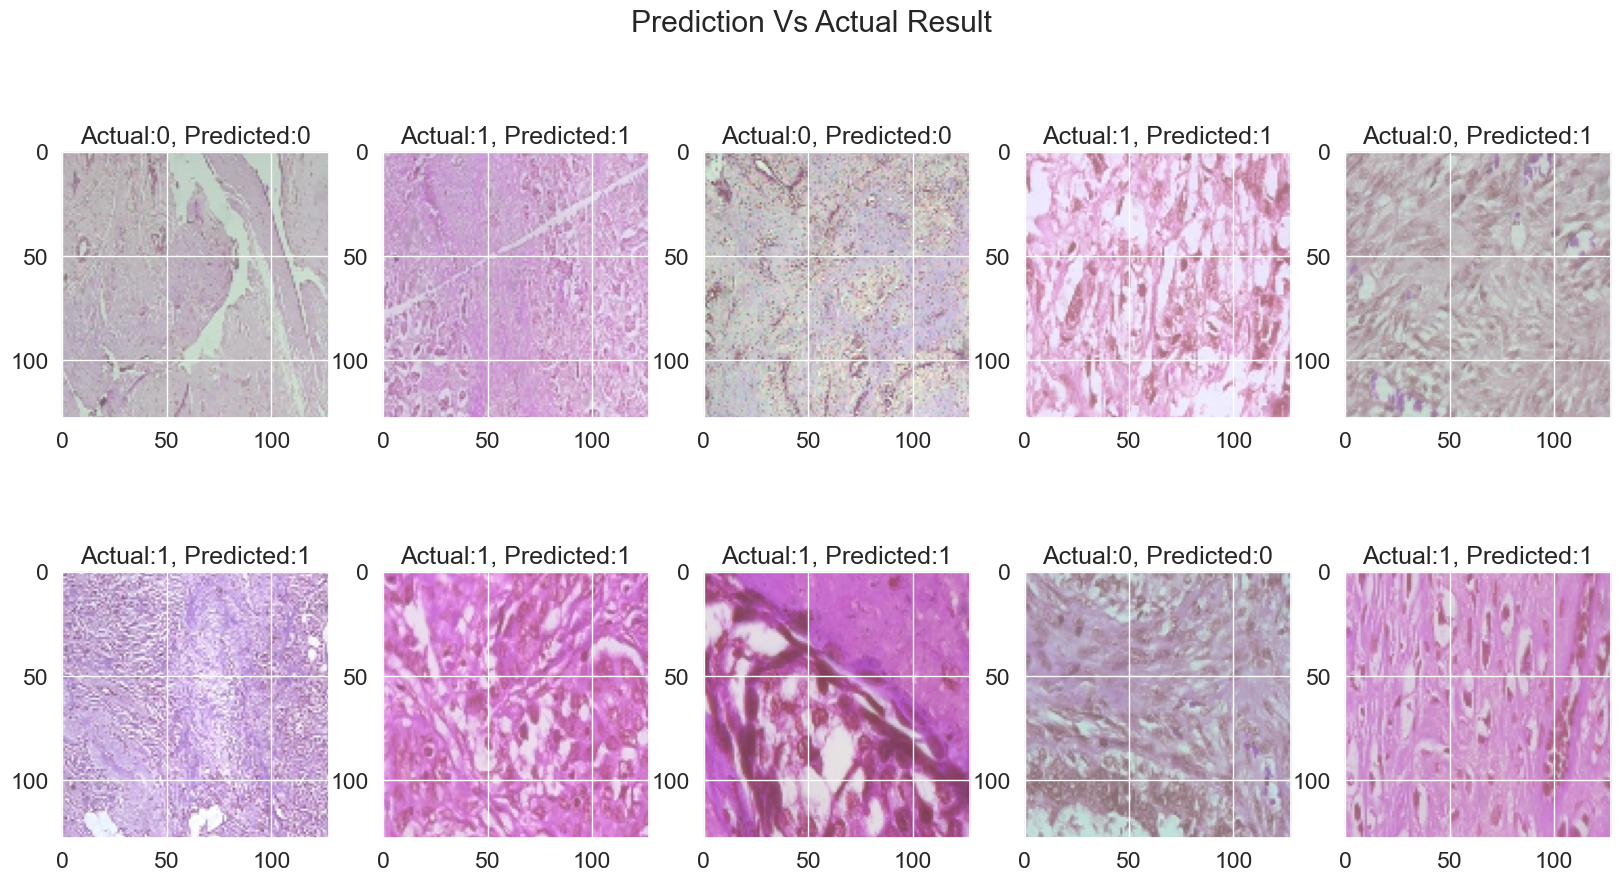

In [62]:
#Plotting results and actual prediction
plt.figure(figsize=(20,10))
plt.suptitle("Prediction Vs Actual Result")
for i in range(0,10):
    string = "Actual:" + str(labels[i]) + ", Predicted:" + str(pred[i])
    plt.subplot(2,5,i+1)
    plt.imshow(test[i])
    plt.title(string)